In [273]:
import numpy as np
from scipy.special import j1  # Bessel function of the first kind of order 1
import scipy.spatial.distance

class Simulation:
# this class SoundSignalGenerator:
    def __init__(self,
                 source_location, 
                 source_frequency,
                 pcd_mic,
                 source_volume_velocity = 0.01,
                 ):
        """
        Initialize the simulation class.
        """

        self.density = None  # Density of the medium
        self.f = source_frequency
        self.Q = source_volume_velocity
        self.source_location = source_location
        self.mic = pcd_mic


    def generate_3d_point_set(self, location, dimensions, density):
        '''
        Generate a set of points within a 3D box.
        location: (x, y, z) coordinates of the box's center
        dimensions: (u, v, w) dimensions of the box
        density: number of points per unit length
        '''
        x, y, z = location
        u, v, w = dimensions

        # Calculate the number of points along each axis
        num_points_x = int(density * u)
        num_points_y = int(density * v)
        num_points_z = int(density * w)

        # Generate linearly spaced points along each axis
        x_points = np.linspace(x-u/2, x + u/2, num_points_x)
        y_points = np.linspace(y-v/2, y + v/2, num_points_y)
        z_points = np.linspace(z, z + w, num_points_z)

        # Create a grid of points
        xv, yv, zv = np.meshgrid(x_points, y_points, z_points, indexing='ij')
        points = np.column_stack((xv.ravel(), yv.ravel(), zv.ravel()))
        
        return points

    def generate_simulation_matrix(self):
        # Perform calculations to generate the simulation matrix
        # and return a 3D matrix
        
        # Example implementation:
        matrix = np.zeros(self.dimensions)
        matrix[0, 0, 0] = 1  # Set the value at the specified location to 1

    def r(self):
        # calculate the distance between the source and the microphone
        # return the distance
        distance = scipy.spatial.distance.cdist(self.mic, self.source_location, metric="euclidean")
        return distance

    def source_pressure(self, t, theta, S):
        
        """
        Calculate the far field approximation using the radiation of piston.
        
        Parameters:
            omega: Angular frequency
            t: Time
            k: Wave number
            rho: Air density
            Q: Volume velocity of the source
            r: distance from piston to object
            a: Radius of the piston, assume to be sqrt(S/pi)
            S: Area of the piston
            theta: Angle between the piston and the microphone
        
        Returns:
            p_hat: Far field pressure due to the piston radiation, approximated
        """
        C = 343
        omega = 2 * np.pi * self.f
        k = omega / C

        r = self.r()
        rho = 1.225

        a = np.sqrt(S/np.pi)
        term = 2 * j1(k * a * np.sin(theta)) / (k * a * np.sin(theta))

        # p_hat = (1j * omega * rho * self.Q * np.exp(1j * (omega * t - k * r))) / (2 * np.pi * r) * term[None, :, None]
        p_hat = (1j * omega * rho * self.Q * np.exp(1j * (omega * t[:, None, None] - k * r))) / (2 * np.pi * r) * term
        p_hat = np.sum(p_hat, axis=-1)
        return p_hat

    def generate_random_Q(self, duration, sample_rate=44100):
        """
        generate white noise
        to make experiments reproducible, set a seed
        """

        t = np.linspace(0, duration, sample_rate)
        np.random.seed(42)
        Q = np.random.randn(int(sample_rate * duration))
        return Q,t
    def cal_dB_SPL(self, pressure):
        """
        Calculate the sound pressure level in dB SPL.
        """
        p_ref = 20e-6
        dB_SPL = 20 * np.log10(np.abs(pressure) / p_ref)
        return dB_SPL
    
    def gen_random_noise(self, duration, sample_rate=44100, amplitude_db = 10, channel = 36):
        """
        generate white noise
        to make experiments reproducible, set a seed
        """

        t = np.linspace(0, duration, sample_rate)
        np.random.seed(42)
        Q = np.random.randn(int(sample_rate * duration), channel)
        Q = Q / np.max(Q)
        Q = 10**(amplitude_db/20) * 20e-6 * Q
        return Q,t
    

In [366]:
import pcd_aligner
import matplotlib.pyplot as plt

cpcd_path = f"../data/pcd/pcd_mic.pcd"
processor = pcd_aligner.PointCloud_PreProcessor(cpcd_path)
processor.load_mic_array()
pcd_mic = np.array(processor.pcd_mic.points)

# shift and addup the pcd_mic for 5 times with +- 0.01m increments in x, y direction
#for i in range(2):
#    for j in range(2):
#        if i == 0 and j == 0:
#            continue
#        else:
#            pcd_mic = np.vstack((pcd_mic, processor.pcd_mic.points[0:11] + np.array([i*0.2, j*0.2, 0])))

#pcd_mic = np.array(processor.pcd_mic.points)

source_frequency = 4000

# source_location = np.array([[0.3, 0.3, 3],[0.3, -0.3, 3],[1, -1, 4],[1, 1, 4]])
source_location = np.array([[-0.2, -0.8, 1],[-0.8, -0.8, 1], [-0.2, 0.8, 1], [-0.8, 0.8, 1]])

simulation = Simulation(
                        source_location=source_location, 
                        source_frequency=source_frequency, pcd_mic=pcd_mic, source_volume_velocity=20e-6)

Q, t = simulation.gen_random_noise(duration=1, sample_rate=44100, amplitude_db = 30, channel = 36)

pointset_location = (0, 0, 0.5)
pointset_dimensions = (2, 2, 0.5)
pointset_density = 15

points = simulation.generate_3d_point_set(pointset_location,
                                          pointset_dimensions,
                                          pointset_density)


mic_pressure = simulation.source_pressure(t = t, theta=0.5*np.pi, S=0.01)

mic_pressure = mic_pressure + Q


In [367]:
import open3d as o3d
# create a plane at z = 0, with x and y in [-1, 1]
density = 20
x = np.linspace(-1, 1, density)
y = np.linspace(-1, 1, density)
X, Y = np.meshgrid(x, y)

plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(np.column_stack((X.ravel(), Y.ravel(), np.zeros(density**2))))

# calculate the pressure at each point
simulation = Simulation(
                        source_location=source_location, 
                        source_frequency=source_frequency, pcd_mic=plane_pcd.points, source_volume_velocity=20e-6)

Q, t = simulation.gen_random_noise(duration=1, sample_rate=44100, amplitude_db = 30, channel = density**2)

plane_pressure = simulation.source_pressure(t = t, theta=0.5*np.pi, S=0.01)

plane_pressure = plane_pressure + Q

In [368]:
from scipy import signal

# calculate the spectrum of plane pressure
f, plane_spl = signal.welch(np.real(plane_pressure), fs=44100, nperseg=1600, scaling = 'spectrum', return_onesided=True
                            , axis=0)
plane_spl = 20 * np.log10(plane_spl/20e-6)

phase_phase_radians = np.arctan2(plane_pressure.imag, plane_pressure.real)

# Convert phase to degrees
phase_degrees = np.degrees(phase_phase_radians)

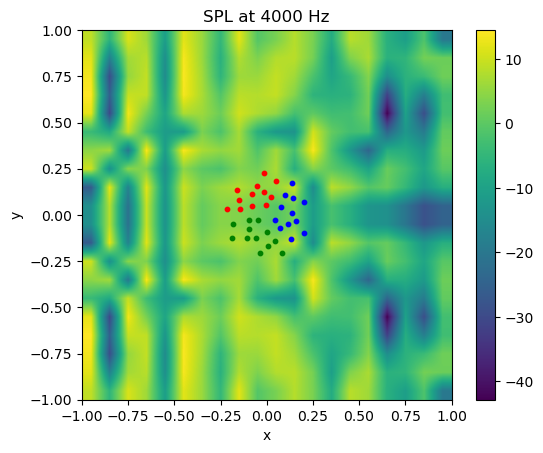

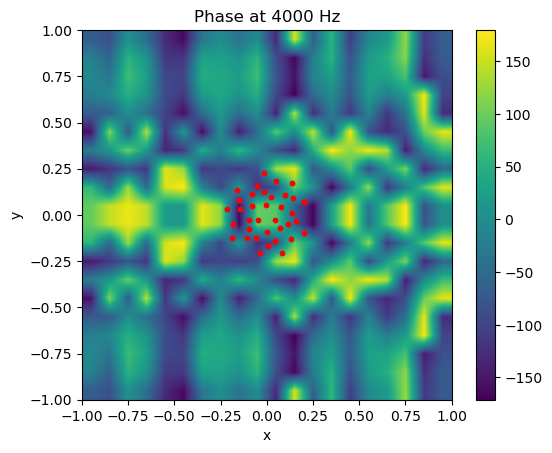

In [369]:

#plot the plane spl in 2d plane, at specific frequency
frequency = source_frequency
index = np.argmin(np.abs(f - frequency))
plane_spl_index = plane_spl[index, :]

plt.figure()
#display the plane spl in 2d plane
plane_spl_index = plane_spl_index.reshape(density, density)
plt.imshow(plane_spl_index, origin='lower', extent=[-1, 1, -1, 1], interpolation='bilinear')
plt.colorbar()
# plot the microphone array as point in the image
plt.scatter(pcd_mic[0:12,0], pcd_mic[0:12,1], c='r', s=10)
plt.scatter(pcd_mic[12:24,0], pcd_mic[12:24,1], c='b', s=10)
plt.scatter(pcd_mic[24:36,0], pcd_mic[24:36,1], c='g', s=10)
plt.title(f'SPL at {frequency} Hz')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#display the plane phase in 2d plane
phase_degrees_index = phase_degrees[index, :]
phase_degrees_index = phase_degrees_index.reshape(density, density)
plt.imshow(phase_degrees_index, origin='lower', extent=[-1, 1, -1, 1], interpolation='bilinear')
plt.colorbar()
# plot the microphone array as point in the image
plt.scatter(pcd_mic[:,0], pcd_mic[:,1], c='r', s=10)
plt.title(f'Phase at {frequency} Hz')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


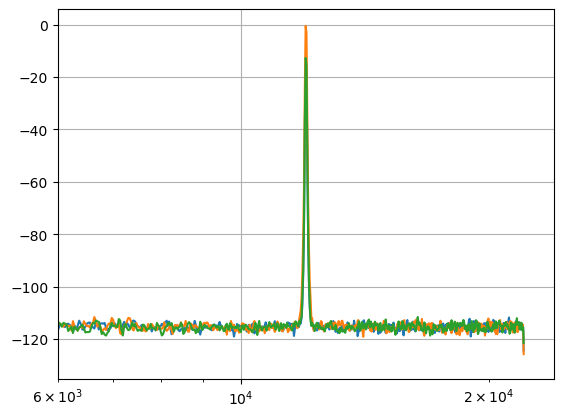

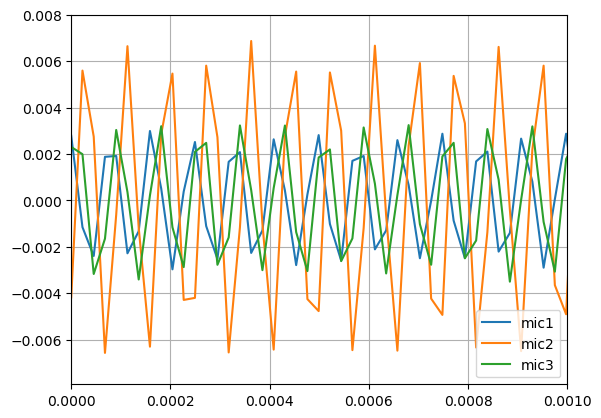

In [350]:

fs = 44100
f, Pxx_den1 = signal.welch(np.real(mic_pressure[:,0]), fs, nperseg=1600, scaling='spectrum', return_onesided=True)
f, Pxx_den2 = signal.welch(np.real(mic_pressure[:,1]), fs, nperseg=1600, scaling='spectrum', return_onesided=True)
f, Pxx_den3 = signal.welch(np.real(mic_pressure[:,2]), fs, nperseg=1600, scaling='spectrum', return_onesided=True)

plt.figure()
plt.semilogx(f, simulation.cal_dB_SPL(Pxx_den1))
plt.semilogx(f, simulation.cal_dB_SPL(Pxx_den2))
plt.semilogx(f, simulation.cal_dB_SPL(Pxx_den3))
plt.grid()

plt.xlim([source_frequency/2, source_frequency*2])

plt.figure()
plt.plot(t, mic_pressure[:,0])
plt.plot(t, mic_pressure[:,1])
plt.plot(t, mic_pressure[:,2])
plt.xlim([0, 0.001])
plt.legend(["mic1", "mic2", "mic3"])
plt.grid()
import open3d as o3d
import xml.etree.ElementTree as ET
from xml.dom import minidom

plt.show()

In [374]:
from scipy.io import loadmat
import numpy as np
import tables

tables.file._open_files.close_all()
fs = int(mic_pressure.shape[1])/1
datamat7 = np.array(mic_pressure.T, dtype='float32')

h5filemat7 = tables.open_file("temp.h5", mode='w', 
                             title='three_sources')
earraymat7 = h5filemat7.create_earray('/', 'time_data', obj=datamat7)
display(earraymat7)
h5filemat7.root.time_data.set_attr('sample_freq',fs)
h5filemat7.close()

C:\Users\ZHLI\AppData\Local\Temp\ipykernel_14168\3485019143.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  datamat7 = np.array(mic_pressure.T, dtype='float32')


HDF5ExtError: HDF5 error back trace

  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5F.c", line 532, in H5Fcreate
    unable to create file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3282, in H5VL_file_create
    file create failed
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3248, in H5VL__file_create
    file create failed
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLnative_file.c", line 63, in H5VL__native_file_create
    unable to create file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5Fint.c", line 1898, in H5F_open
    unable to lock the file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5FD.c", line 1625, in H5FD_lock
    driver lock request failed
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5FDsec2.c", line 1002, in H5FD__sec2_lock
    unable to lock file, errno = 0, error message = 'No error', Win32 GetLastError() = 33

End of HDF5 error back trace

Unable to open/create file 'temp.h5'

In [ ]:
import open3d as o3d
import xml.etree.ElementTree as ET
from xml.dom import minidom
pointset_pcd = o3d.geometry.PointCloud()
pointset_pcd.points = o3d.utility.Vector3dVector(points)

def save_pcd_to_xml(pcd = None, xml_filename = "pcd_temp.xml", subgrid_name="default"):
    """
    Save Open3D point cloud coordinates to an XML file.

    :param pcd: Open3D point cloud object
    :param xml_filename: Path to the output XML file
    :param subgrid_name: Name of the subgrid (default is 'default')
    """
    # Extract points from the point cloud

    points = np.asarray(pcd.points)

    # Create XML structure
    root = ET.Element('root')
    for point in points:
        pos_element = ET.SubElement(root, 'pos', {
            'x': str(point[0]),
            'y': str(point[1]),
            'z': str(point[2]),
            'subgrid': subgrid_name
        })

    # Beautify and write to XML file
    xml_str = minidom.parseString(ET.tostring(root)).toprettyxml(indent="   ")
    with open(xml_filename, "w") as xml_file:
        xml_file.write(xml_str)

save_pcd_to_xml(pcd = pointset_pcd, xml_filename = "pcd_temp.xml", subgrid_name="default")
save_pcd_to_xml(pcd = pcd_mic, xml_filename = "pcd_mic_temp.xml", subgrid_name="default")

In [ ]:
from os import path

# imports from acoular
import acoular
from acoular import __file__ as bpath, L_p, MicGeom, PowerSpectra,\
RectGrid3D, BeamformerBase, BeamformerCleansc, \
SteeringVector, WNoiseGenerator, PointSource, SourceMixer

# other imports
from numpy import mgrid, arange, array, arccos, pi, cos, sin, sum
import mpl_toolkits.mplot3d
from pylab import figure, show, scatter, subplot, imshow, title, colorbar,\
xlabel, ylabel


micgeofile = 'pcd_mic_temp.xml'
# generate test data, in real life this would come from an array measurement
mg = MicGeom( from_file=micgeofile)

ts = acoular.TimeSamples(name="temp.h5")

ps = acoular.PowerSpectra( time_data=ts, block_size=2048, window="Hanning" )

# Create an instance of ImportGrid
grid_importer = acoular.ImportGrid()

# Set the path to your XML file
grid_importer.from_file = 'pcd_temp.xml'

# Call the method to import grid positions
grid_importer.import_gpos()

#rg = acoular.RectGrid( x_min=-1, x_max=1,
                       #y_min=-1, y_max=1,
                       #z=0.5, increment=0.01 )

st = acoular.SteeringVector(mics=mg )
st.grid = grid_importer
st.steer_type = 'true location'


In [6]:
# this block is for testing, allowd to reload the module soundfieldanalysis
%load_ext autoreload
%aimport SoundFieldAnalysis
%autoreload 1
%aimport

Modules to reload:
SoundFieldAnalysis

Modules to skip:



In [308]:
# create a dropdown menu to select a mat file

import os
import glob
import ipywidgets as widgets
from IPython.display import display

# list the mat files in the folder and create a dropdown menu
folder_path = 'Recordings/'
mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

# crate a dropdown menu
recording_dropdown = widgets.Dropdown(
    options=mat_files,
    description='Select the recording file:',
    disabled=False,
)

display(recording_dropdown)

Dropdown(description='Select the recording file:', options=('AP-side-0.6m-12.8kHz-1k6fft.mat', 'bgNoise-HP2-0.…

In [309]:
from data_importer import DataExtractor
extractor = DataExtractor(f'Recordings/{recording_dropdown.value}')
recording = extractor.load_data()

In [370]:
from SoundFieldAnalysis import SoundFieldAnalysis
import open3d as o3d

simulation_data = np.real(mic_pressure.T)
# simulation_data = recording

pointset_pcd = o3d.geometry.PointCloud()
pointset_pcd.points = o3d.utility.Vector3dVector(points)
freq = source_frequency
mode = 'DAS'

cbf_r = []
cbf_p = []

# split the pcd_mic and simulation_data into 3 parts
for i in range(3):
    o3d_pcd_mic = o3d.geometry.PointCloud()
    o3d_pcd_mic.points = o3d.utility.Vector3dVector(pcd_mic[i*12:(i+1)*12])
    simulation_data_split = simulation_data[i*12:(i+1)*12,:]

    # initialize the variables
    BF_analysis = SoundFieldAnalysis(o3d_pcd_mic, simulation_data_split, pointset_pcd, freq=freq)
    BF_analysis.calculate_sparse(T = 1)
    BF_analysis.calculate_csm()
    # get the result and add it to the list
    cbf_result, cbf_pressure = BF_analysis.gen_result(mode)
    cbf_r.append(cbf_result)
    cbf_p.append(cbf_pressure)

print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

cbf_pressure = (cbf_p[0] * cbf_p[1] * cbf_p[2])**(1/3)

c:\ZIM\MasterThesisProject\Stage4\3d_beamforming\SoundFieldAnalysis.py:471: RuntimeWarning: invalid value encountered in log10
  


the calculated frequency is:  3996.5625


In [265]:
from SoundFieldAnalysis import SoundFieldAnalysis
import open3d as o3d

simulation_data = np.real(mic_pressure.T)
simulation_data = recording

pointset_pcd = o3d.geometry.PointCloud()
pointset_pcd.points = o3d.utility.Vector3dVector(points)

freq = source_frequency
mode = 'DAS'
# initialize the variables
BF_analysis = SoundFieldAnalysis(processor.pcd_mic, simulation_data, pointset_pcd, freq=freq)
BF_analysis.calculate_sparse(T = 1)
BF_analysis.calculate_csm()
# inorder to avoid re-calculation of the same thing
cbf_result, cbf_pressure = BF_analysis.gen_result(mode)


KeyboardInterrupt: 

In [87]:
# calculate the transformed origin
transformed_origin = BF_analysis.find_transformed_origin(BF_analysis.origional_mic_pcd[0:2, :], BF_analysis.mic_array[0:2, :])
# calculate the distance from the origin to the focus points
r = scipy.spatial.distance.cdist([transformed_origin], points, metric="euclidean")
# calculate the distance from the mic array to individual microphone points
rm = scipy.spatial.distance.cdist(BF_analysis.mic_array, [transformed_origin], metric="euclidean")

rv = rm - r


In [88]:

vm = (np.exp(-1j * BF_analysis.k * rv)/rv)[:,None,:]
f, Pxx_den = signal.welch(np.real(mic_pressure), fs, nperseg=1600, scaling='spectrum', axis = 0, return_onesided=True)

vm = vm * Pxx_den.swapaxes(1, 0)[:, None, BF_analysis.index]

h = vm * vm.conj()

g = BF_analysis.S[:,:,None]

J4 = ( h.swapaxes(1, 0).conj() * g )**2 / (h.swapaxes(1,0).conj() * h)
J4 = np.sum(J4, axis=(0, 1))

print("calculated frquency is: ", f[BF_analysis.index])

calculated frquency is:  6008.625


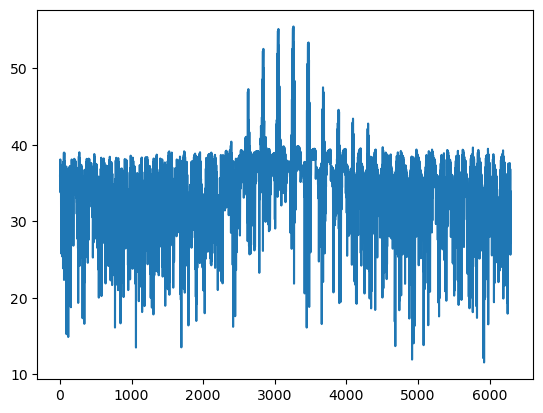

In [371]:
def cal_sum(x):
    return simulation.cal_dB_SPL(np.sum(x, axis=(0, 1)))

plt.plot(simulation.cal_dB_SPL((cbf_pressure)))

In [14]:

# calculate the sound pressure
h = np.real(Vmn)
g = self.S[:,:,None]
J4 = ( h.swapaxes(1, 0).conj() * g )**2 / h.swapaxes(1,0).conj() * h
#Jup = self.S[:, :, None] * (Vmn)
# result = 1 / np.sqrt(36*35) * (np.real(Jup.sum(axis=(0, 1))) / np.sqrt(Vmn2.sum(axis=(0, 1))))
# result = 1 / np.sqrt(36*35) * np.real(Jup.sum(axis=(0, 1)))
# result = 1 / np.sqrt(36*35) * ((Jup.sum(axis=(0, 1))) / (Vmn2.sum(axis=(0, 1))))
J4 = (J4.sum(axis=(0, 1)))

NameError: name 'Vmn' is not defined

C:\Users\ZHLI\AppData\Local\Temp\ipykernel_14168\2705534073.py:113: RuntimeWarning: divide by zero encountered in log10
  dB_SPL = 20 * np.log10(np.abs(pressure) / p_ref)


Text(0, 0.5, 'Mic index')

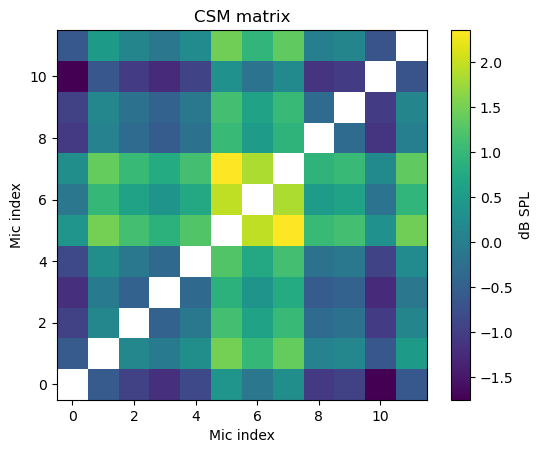

In [314]:
# plot the csm matrix with microphone array
# on the pcd_mic points

csm = BF_analysis.S

plt.figure()
plt.imshow(simulation.cal_dB_SPL(np.real(csm)), origin='lower')
plt.colorbar(label='dB SPL')
plt.title('CSM matrix')
plt.xlabel('Mic index')
plt.ylabel('Mic index')


In [63]:
from os import path

# imports from acoular

from acoular import __file__ as bpath, L_p, MicGeom, PowerSpectra,\
RectGrid3D, BeamformerBase, BeamformerCleansc, \
SteeringVector, WNoiseGenerator, PointSource, SourceMixer

# other imports
from numpy import mgrid, arange, array, arccos, pi, cos, sin, sum
import mpl_toolkits.mplot3d
from pylab import figure, show, scatter, subplot, imshow, title, colorbar,\
xlabel, ylabel

#===============================================================================
# First, we define the microphone geometry.
#===============================================================================

micgeofile = 'P36D45_f14.xml'
# generate test data, in real life this would come from an array measurement
m = MicGeom( from_file=micgeofile)

#===============================================================================
# Now, the sources (signals and types/positions) are defined.
#===============================================================================
sfreq = 51200 
duration = 1
nsamples = duration*sfreq

n1 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=1 )
n2 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=2, rms=0.5 )
n3 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=3, rms=0.25 )
p1 = PointSource( signal=n1, mics=m,  loc=(-0.1,-0.1,0.3) )
p2 = PointSource( signal=n2, mics=m,  loc=(0.15,0,0.17) )
p3 = PointSource( signal=n3, mics=m,  loc=(0,0.1,0.25) )
pa = SourceMixer( sources=[p1,p2,p3])


#===============================================================================
# the 3D grid (very coarse to enable fast computation for this example)
#===============================================================================

g = RectGrid3D(x_min=-0.2, x_max=0.2, 
               y_min=-0.2, y_max=0.2, 
               z_min=0.1, z_max=0.36, 
               increment=0.02)

#===============================================================================
# The following provides the cross spectral matrix and defines the CLEAN-SC beamformer.
# To be really fast, we restrict ourselves to only 10 frequencies
# in the range 2000 - 6000 Hz (5*400 - 15*400)
#===============================================================================

f = PowerSpectra(time_data=pa, 
                 window='Hanning', 
                 overlap='50%', 
                 block_size=128, 
                 ind_low=5, ind_high=16)
st = SteeringVector(grid=g, mics=m, steer_type='true location') 
b = BeamformerCleansc(freq_data=f, steer=st)

#===============================================================================
# Calculate the result for 4 kHz octave band
#===============================================================================

map = b.synthetic(4000,1)


TraitError: The 'time_data' trait of a PowerSpectra instance must be a SamplesGenerator or None, but a value of array([[ 3.42788046e-03+0.00091892j,  1.54061523e-03+0.00313874j,
        -1.38038815e-03+0.00320107j, ...,  4.03050580e-04-0.00345562j,
         2.83830762e-03-0.00193254j,  3.55926493e-03+0.00091892j],
       [-3.26706097e-03-0.00054338j, -1.98686775e-03-0.00280748j,
         1.19955114e-03-0.0031418j , ..., -1.17857560e-04+0.00329232j,
        -2.54957858e-03+0.00209423j, -3.27983690e-03-0.00054338j],
       [ 4.00724569e-03-0.00036299j,  2.66688836e-03+0.00271913j,
        -5.37523705e-04+0.00393219j, ..., -9.65718677e-04-0.00383164j,
         2.33238824e-03-0.0031956j ,  4.03506423e-03-0.00036299j],
       ...,
       [-5.58218840e-04+0.00011952j, -4.49913821e-04-0.00023485j,
        -6.24293428e-06-0.0004278j , ...,  2.03922410e-04+0.00039469j,
        -1.93418888e-04+0.00039175j, -3.99480025e-04+0.00011952j],
       [ 7.40101092e-03-0.0028562j ,  6.98823087e-03+0.00362553j,
         2.07394365e-03+0.00761517j, ..., -3.80856936e-03-0.00682396j,
         2.61280212e-03-0.00737465j,  7.35782920e-03-0.0028562j ],
       [-6.41306322e-03+0.00444777j, -7.24856793e-03-0.00179494j,
        -3.51591350e-03-0.00680386j, ...,  5.13569188e-03+0.00557178j,
        -6.92800730e-04+0.00763321j, -6.46001551e-03+0.00444777j]]) <class 'numpy.ndarray'> was specified.

In [66]:
import acoular
acoular.TimeSamples()

AttributeError: module 'acoular' has no attribute 'timesamples'

In [372]:
plotter, p_range = BF_analysis.plot(simulation.cal_dB_SPL((simulation.cal_dB_SPL(np.abs(cbf_pressure)))), dynamic_range=4, max_crop=0,  plot_mesh = False, opacity='linear')
# plotter.add_title(f"Beamforming result at {freq} Hz")
plotter.show()

Widget(value="<iframe src='http://localhost:62420/index.html?ui=P_0x1dd1eba3b50_98&reconnect=auto' style='widt…

In [300]:
plotter_add_slice, cloud = BF_analysis.add_slicer(plotter, mode, p_range = None, plane='xy', 
                                           center = [0,0],position=2, 
                                           size=[2, 2], plot_mesh=False,
                                           dynamic_range=20, density=100)

c:\ZIM\MasterThesisProject\Stage4\3d_beamforming\SoundFieldAnalysis.py:470: RuntimeWarning: invalid value encountered in log10
  plotc = 20 * np.log10(np.real(result_J / 20e-6))
Task exception was never retrieved
future: <Task finished name='Task-6261' coro=<WslinkHandler.sendWrappedMessage() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py:423> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  F

In [ ]:
import pyvista as pv
plotter_plane = pv.Plotter()
plotter_plane.add_mesh(cloud, cmap='rainbow', scalars='Sound Pressure(dB)',show_scalar_bar = True, point_size = 6)
plotter_plane.show()

Widget(value="<iframe src='http://localhost:62420/index.html?ui=P_0x1dc3a67aaa0_81&reconnect=auto' style='widt…

Exception raised
ConnectionResetError('Cannot write to closing transport')
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 340, in onMessage
    await self.sendWrappedMessage(
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\Ap

 JS Error => Malformed message:  {"wslink": "1.0", "id": "publish:trame.vtk.delta:0", "result": {"parent": "0x0", "id": 82, "type": "vtkWin32OpenGLRenderWindow", "properties": {"numberOfLayers": 2}, "dependencies": [{"parent": "000001dc7b807410", "id": "000001dcf5d21960", "type": "vtkOpenGLRenderer", "properties": {"background": [1.0, 1.0, 1.0], "background2": [0.2, 0.2, 0.2], "viewport": [0.0, 0.0, 1.0, 1.0], "twoSidedLighting": 1, "lightFollowCamera": 1, "layer": 0, "preserveColorBuffer": 0, "preserveDepthBuffer": 0, "nearClippingPlaneTolerance": 0.001, "clippingRangeExpansion": 0.5, "useShadows": 0, "useDepthPeeling": 0, "occlusionRatio": 0.0, "maximumNumberOfPeels": 4, "interactive": 1}, "dependencies": [{"parent": "000001dcf5d21960", "id": "000001dbd32d1b70", "type": "vtkOpenGLCamera", "properties": {"focalPoint": [0.0, 0.0, 2.0], "position": [3.1547005383792524, 3.1547005383792524, 5.154700538379252], "viewUp": [0.0, 0.0, 1.0], "clippingRange": [3.1116065276116682, 8.438587988004

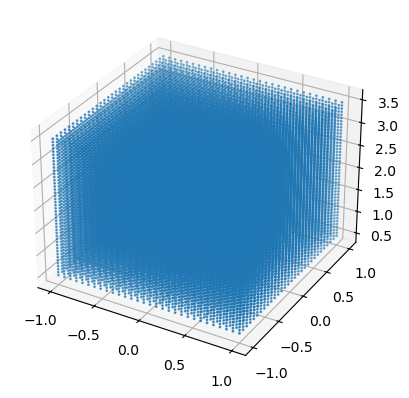

In [ ]:


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)

In [ ]:
complex_array = np.array([1+2j, 3+4j, 5+6j])

# Multiplying the array by 2
result = np.sqrt(complex_array)

print(result)

[1.27201965+0.78615138j 2.        +1.j         2.53083481+1.18537962j]
